In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import time
import math
from scipy.stats import spearmanr #to compute spearman correlation
from scipy.stats import pearsonr #to compute pearson correlation
from scipy.stats import kendalltau #to compute kendall tau correlation

In [2]:
data_folder = './Data/' # all my data is in one folder 
path_sources_final='sources_final.csv'
path_control_grp='sources_1.csv'
path_df1='df_1.csv'
path_df2='df_2.csv'

In [3]:
#getting our necessary datasets
df_sources_final=pd.read_csv(data_folder + path_sources_final) #maps channel_id to extreme grp corresponding
df_1=pd.read_csv(data_folder + path_df1)
df_2=pd.read_csv(data_folder + path_df2)

In [4]:
#combining the two dataframes from the two folders 
#(should do it right from the begining? I was afraid it would slow things to have a dataframe so big)
df=pd.concat([df_1, df_2],ignore_index=True)

In [5]:
#extracting only necessary columns
df_sources=df_sources_final[["Category", "Id"]]
df_sources.rename(columns = {'Id':'channel_id'}, inplace = True)

C:\Users\anyam\AppData\Local\Temp\ipykernel_41276\2487438044.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sources.rename(columns = {'Id':'channel_id'}, inplace = True)


In [6]:
df_sources.head(5)

,Category,channel_id
0,Alt-lite,UCfDdlNLRVb1h3_7Xh-WhL3w
1,Alt-lite,UCso6oQ3qy7z61Fr8b0WNBMw
2,Alt-lite,UCplXdu0g94UynzYCmO2zOjw
3,Alt-lite,UCl3RCEtooHD5bhPCHJw3btA
4,Alt-lite,UCbukZErY9SjdGTHabMzY7qg


In [7]:
#checking for NaN values
print("there are", len(df_sources[df_sources.isnull().any(axis=1)]), "Nan values")

there are 0 Nan values


In [8]:
df.head()

,Unnamed: 0,video_map,view_count,upload_date,toxicity,severe_toxicity,obscene,identity_attack,insult,threat,sexual_explicit,channel_id
0,0,0,977.0,20170920,0.136365,0.001002,0.051841,0.006676,0.056322,0.000422,0.072277,UC_7Bt0vnvdJqAwF8Ow8iT0g
1,1,1,408.0,20170905,0.014895,0.000007,0.000330,0.000946,0.000885,0.002700,0.000118,UC_7Bt0vnvdJqAwF8Ow8iT0g
2,2,2,523.0,20170828,0.034177,0.000006,0.000391,0.000210,0.017617,0.000103,0.000400,UC_7Bt0vnvdJqAwF8Ow8iT0g
3,3,3,1446.0,20170628,0.073253,0.000177,0.039672,0.005961,0.020233,0.002046,0.000521,UC_7Bt0vnvdJqAwF8Ow8iT0g
4,4,4,1859.0,20170531,0.108773,0.008326,0.049040,0.025089,0.033552,0.019227,0.009504,UC_7Bt0vnvdJqAwF8Ow8iT0g


In [9]:
#checking for NaN values
print("there are", len(df[df.isnull().any(axis=1)]), "Nan values")

there are 0 Nan values


In [10]:
#checking if nb of channels in df_1 is the same as in df_sources
print(len(pd.unique(df['channel_id'])), len(pd.unique(df_sources['channel_id'])))

697 676


In [11]:
#we have more channels in df than in df_sources but the difference is small

In [12]:
df_final=df.merge(df_sources, how='left', on='channel_id')

In [13]:
df_final

,Unnamed: 0,video_map,view_count,upload_date,toxicity,severe_toxicity,obscene,identity_attack,insult,threat,sexual_explicit,channel_id,Category
0,0,0,977.0,20170920,0.136365,0.001002,0.051841,0.006676,0.056322,0.000422,0.072277,UC_7Bt0vnvdJqAwF8Ow8iT0g,MRA
1,1,1,408.0,20170905,0.014895,0.000007,0.000330,0.000946,0.000885,0.002700,0.000118,UC_7Bt0vnvdJqAwF8Ow8iT0g,MRA
2,2,2,523.0,20170828,0.034177,0.000006,0.000391,0.000210,0.017617,0.000103,0.000400,UC_7Bt0vnvdJqAwF8Ow8iT0g,MRA
3,3,3,1446.0,20170628,0.073253,0.000177,0.039672,0.005961,0.020233,0.002046,0.000521,UC_7Bt0vnvdJqAwF8Ow8iT0g,MRA
4,4,4,1859.0,20170531,0.108773,0.008326,0.049040,0.025089,0.033552,0.019227,0.009504,UC_7Bt0vnvdJqAwF8Ow8iT0g,MRA
...,...,...,...,...,...,...,...,...,...,...,...,...,...
518458,150459,798,56069.0,20170127,0.327090,0.013587,0.205679,0.050272,0.182447,0.001762,0.053731,UC0aVoboXBUx2-tVIWHc3W2Q,Alt-lite
518459,150460,799,154838.0,20161018,0.209794,0.007211,0.134747,0.027038,0.094364,0.010686,0.024407,UC0aVoboXBUx2-tVIWHc3W2Q,Alt-lite
518460,150461,800,30093.0,20180326,0.237014,0.004566,0.083292,0.062911,0.147315,0.001810,0.019613,UC0aVoboXBUx2-tVIWHc3W2Q,Alt-lite
518461,150462,801,93406.0,20171219,0.309945,0.009368,0.155549,0.086939,0.165149,0.011248,0.023771,UC0aVoboXBUx2-tVIWHc3W2Q,Alt-lite


In [14]:
#overwriting the category for the channels belonging to the control group
df_control_=pd.read_csv(data_folder + path_control_grp) #maps channel_id to extreme grp corresponding

In [15]:
#list of channels belonging to control grp
list_control_=(df_control_[df_control_["Data Collection step"]=='control'].Id).tolist()

In [16]:
df_final.loc[df_final["channel_id"].isin(list_control_), "Category"] = 'control'

In [17]:
#checking for NaN values
nb_Nan=len(df_final[df_final.isnull().any(axis=1)])
print("there are", nb_Nan, "Nan values which corresponds to", nb_Nan*100/len(df_final), "% of the dataframe")

there are 1998 Nan values which corresponds to 0.3853698335271755 % of the dataframe


In [18]:
#very little Nan values, we won't be using channels where the category is Nan (unknown)

In [19]:
#Notice None means "not associated to anything" and not "Nan" 
df_final.Category.value_counts()

control                  332815
Alt-lite                  63667
Intellectual Dark Web     34252
PUA                       27508
MGTOW                     19932
NONE                      14793
Alt-right                 14208
MRA                        5613
Incel                      3468
PUA                         209
Name: Category, dtype: int64

In [20]:
# correct the duplicated category
df_final.loc[df_final.Category == 'PUA ', 'Category'] = 'PUA'

#MGTOW men going their own way, anti feminist misogynistic politic group

#MRA men's rights activist (again anti feminist)

#Incel a member of an online community of young men who consider themselves unable to attract women sexually, 
#typically associated with views that are hostile towards women and men who are sexually active:

#Pick up : online community sharing tips on how to pick up women

## Analysis of toxicity level through time

Now that we have our dataframe and all the values we want we can start our analysis. 
We're keeping only Alt-lite, Alt-right, Intellectual Dark Web channels and control channels. 

In [21]:
# some lists
list_categories = ['Alt-lite', 'Alt-right', 'Intellectual Dark Web', 'control']
list_subcat_tox = ['severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat', 'sexual_explicit']

# change the format of the upload date, and add a column of month created
df_final.upload_date = pd.to_datetime(df_final.upload_date, format='%Y%m%d')
df_final["month_created"] = df_final.upload_date.apply(lambda x: pd.to_datetime(x.strftime('%Y-%m')))

# we study the dataframe of categories in list_categories
df_final_cat=df_final.loc[df_final['Category'].isin(list_categories)]
df_final_cat.head(5)

,Unnamed: 0,video_map,view_count,upload_date,toxicity,severe_toxicity,obscene,identity_attack,insult,threat,sexual_explicit,channel_id,Category,month_created
43,43,0,17848.0,2019-04-19,0.236428,0.005802,0.084186,0.016237,0.168279,0.004983,0.018029,UCzk08fzh5c_BhjQa1w35wtA,Intellectual Dark Web,2019-04-01
44,44,1,117010.0,2019-03-06,0.297070,0.006356,0.114177,0.059876,0.178619,0.009690,0.014943,UCzk08fzh5c_BhjQa1w35wtA,Intellectual Dark Web,2019-03-01
45,45,2,156126.0,2019-01-17,0.236951,0.005025,0.103356,0.031652,0.137247,0.005331,0.014238,UCzk08fzh5c_BhjQa1w35wtA,Intellectual Dark Web,2019-01-01
46,46,3,55901.0,2019-01-05,0.131668,0.001976,0.053593,0.006822,0.069572,0.005718,0.005403,UCzk08fzh5c_BhjQa1w35wtA,Intellectual Dark Web,2019-01-01
47,47,4,41908.0,2018-12-18,0.153443,0.001315,0.071632,0.028211,0.068691,0.006184,0.003500,UCzk08fzh5c_BhjQa1w35wtA,Intellectual Dark Web,2018-12-01


Text(0.5, 0, 'Month')

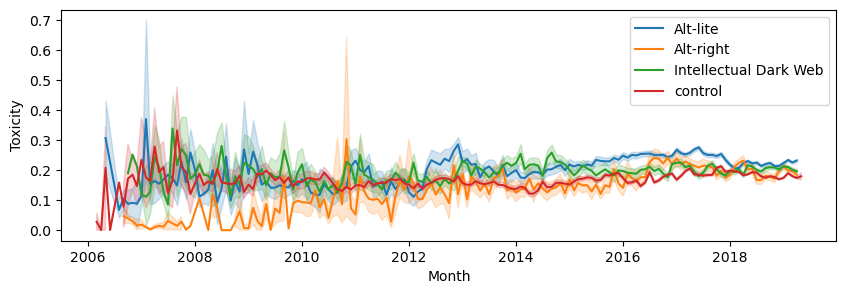

In [22]:
fig, axs = plt.subplots(1, 1, figsize=(10,3))

for category in list_categories:
    sns.lineplot(x="month_created", y="toxicity", data=df_final_cat[df_final_cat['Category'] == category],
            label=category)
axs.set_ylabel("Toxicity")
axs.set_xlabel("Month")

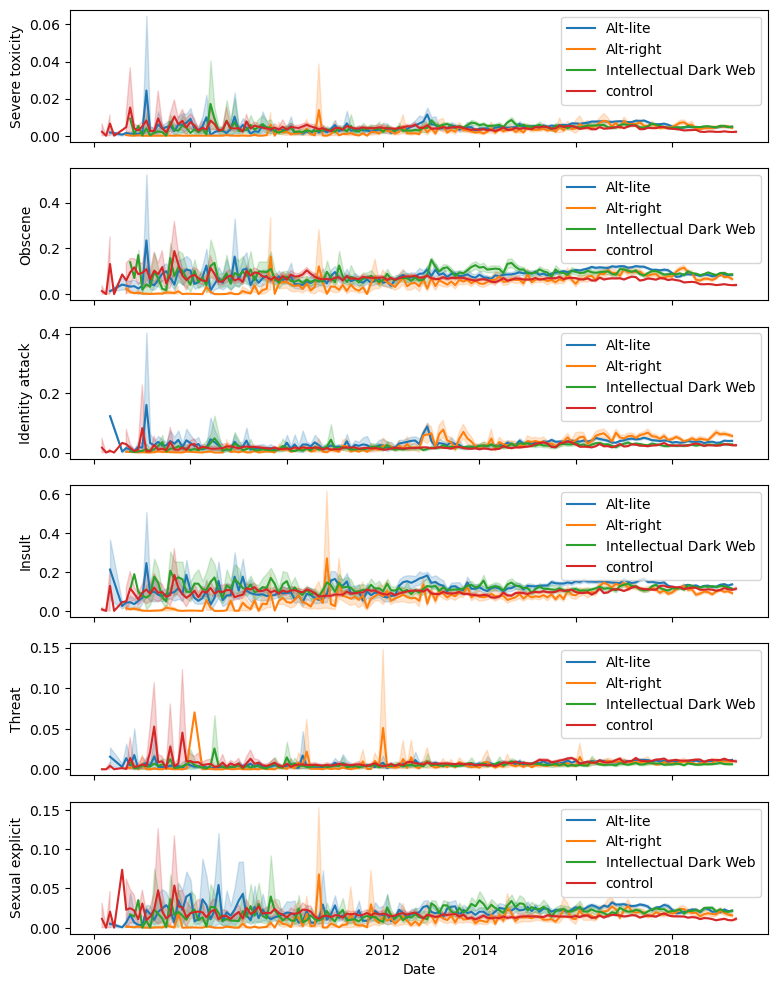

In [23]:
# prints the subcategories of toxicity over time. 
# takes about 45 sec to load
fig, axs = plt.subplots(6,1, figsize=(9,12), sharex=True)
list_subcat_tox_titles = ['Severe toxicity', 'Obscene', 'Identity attack', 'Insult', 'Threat', 'Sexual explicit']


for index, subcat in enumerate(list_subcat_tox):
    for category in list_categories:
        sns.lineplot(x="month_created", y=subcat, data=df_final_cat[df_final_cat['Category'] == category],
            label=category, ax = axs[index])
    axs[index].set_ylabel(list_subcat_tox_titles[index])
    axs[index].set_xlabel("Date")

#### If we look only after 2014:

Text(0.5, 0, 'Month')

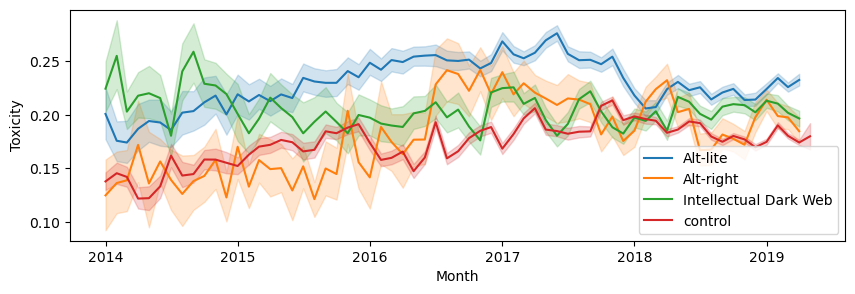

In [24]:
df_after2014 = df_final_cat[df_final_cat.upload_date >= pd.to_datetime("2014-01")]

# plot the toxicity
fig, axs = plt.subplots(1, 1, figsize=(10,3))

for category in list_categories:
    sns.lineplot(x="month_created", y="toxicity", data=df_after2014[df_after2014['Category'] == category],
            label=category)
axs.set_ylabel("Toxicity")
axs.set_xlabel("Month")

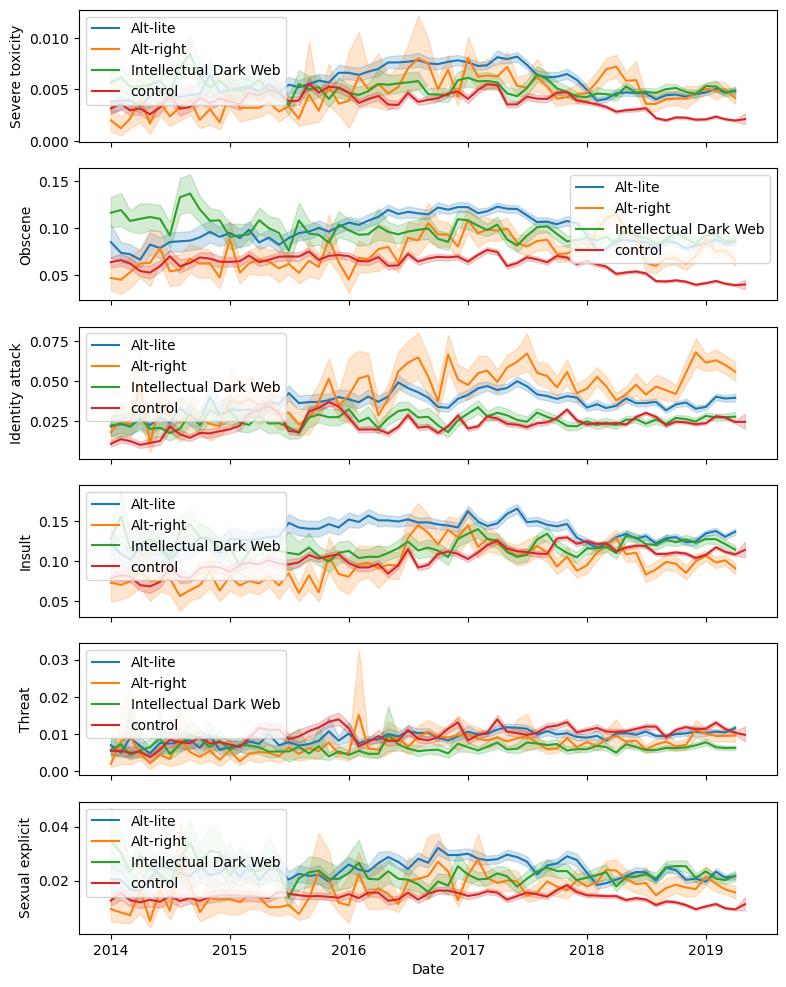

In [25]:
# prints the subcategories of toxicity over time. 
# takes about 45 sec to load

fig, axs = plt.subplots(6,1, figsize=(9,12), sharex=True)


for index, subcat in enumerate(list_subcat_tox):
    for category in list_categories:
        sns.lineplot(x="month_created", y=subcat, data=df_after2014[df_after2014['Category'] == category],
            label=category, ax = axs[index])
    axs[index].set_ylabel(list_subcat_tox_titles[index])
    axs[index].set_xlabel("Date")


For each category of toxicity, we observe different behaviours. 
* Toxicity: 
* Severe toxicity: (SMALL SCALE!) 
* Obscene: 
* Identity attack: 
* Insult: 
* Threat: (SMALL SCALE!)
* Sexual Explicit: 

# Looking at all categories of channels
We study the evolution of all toxicity categories, for all categories of channels.

In [26]:
list_all_cat = df_final.Category.dropna().unique().tolist()
list_all_cat.remove('NONE')
list_all_cat

['MRA',
 'Intellectual Dark Web',
 'Alt-right',
 'PUA',
 'control',
 'MGTOW',
 'Alt-lite',
 'Incel']

In [27]:
df_final_allcat=df_final.loc[df_final['Category'].isin(list_all_cat)]
df_final_allcat = df_final_allcat[df_final_allcat.upload_date >= pd.to_datetime("2014-01")]
df_final_allcat.head(5)

,Unnamed: 0,video_map,view_count,upload_date,toxicity,severe_toxicity,obscene,identity_attack,insult,threat,sexual_explicit,channel_id,Category,month_created
0,0,0,977.0,2017-09-20,0.136365,0.001002,0.051841,0.006676,0.056322,0.000422,0.072277,UC_7Bt0vnvdJqAwF8Ow8iT0g,MRA,2017-09-01
1,1,1,408.0,2017-09-05,0.014895,0.000007,0.000330,0.000946,0.000885,0.002700,0.000118,UC_7Bt0vnvdJqAwF8Ow8iT0g,MRA,2017-09-01
2,2,2,523.0,2017-08-28,0.034177,0.000006,0.000391,0.000210,0.017617,0.000103,0.000400,UC_7Bt0vnvdJqAwF8Ow8iT0g,MRA,2017-08-01
3,3,3,1446.0,2017-06-28,0.073253,0.000177,0.039672,0.005961,0.020233,0.002046,0.000521,UC_7Bt0vnvdJqAwF8Ow8iT0g,MRA,2017-06-01
4,4,4,1859.0,2017-05-31,0.108773,0.008326,0.049040,0.025089,0.033552,0.019227,0.009504,UC_7Bt0vnvdJqAwF8Ow8iT0g,MRA,2017-05-01


(-0.004682617172159426, 0.04)

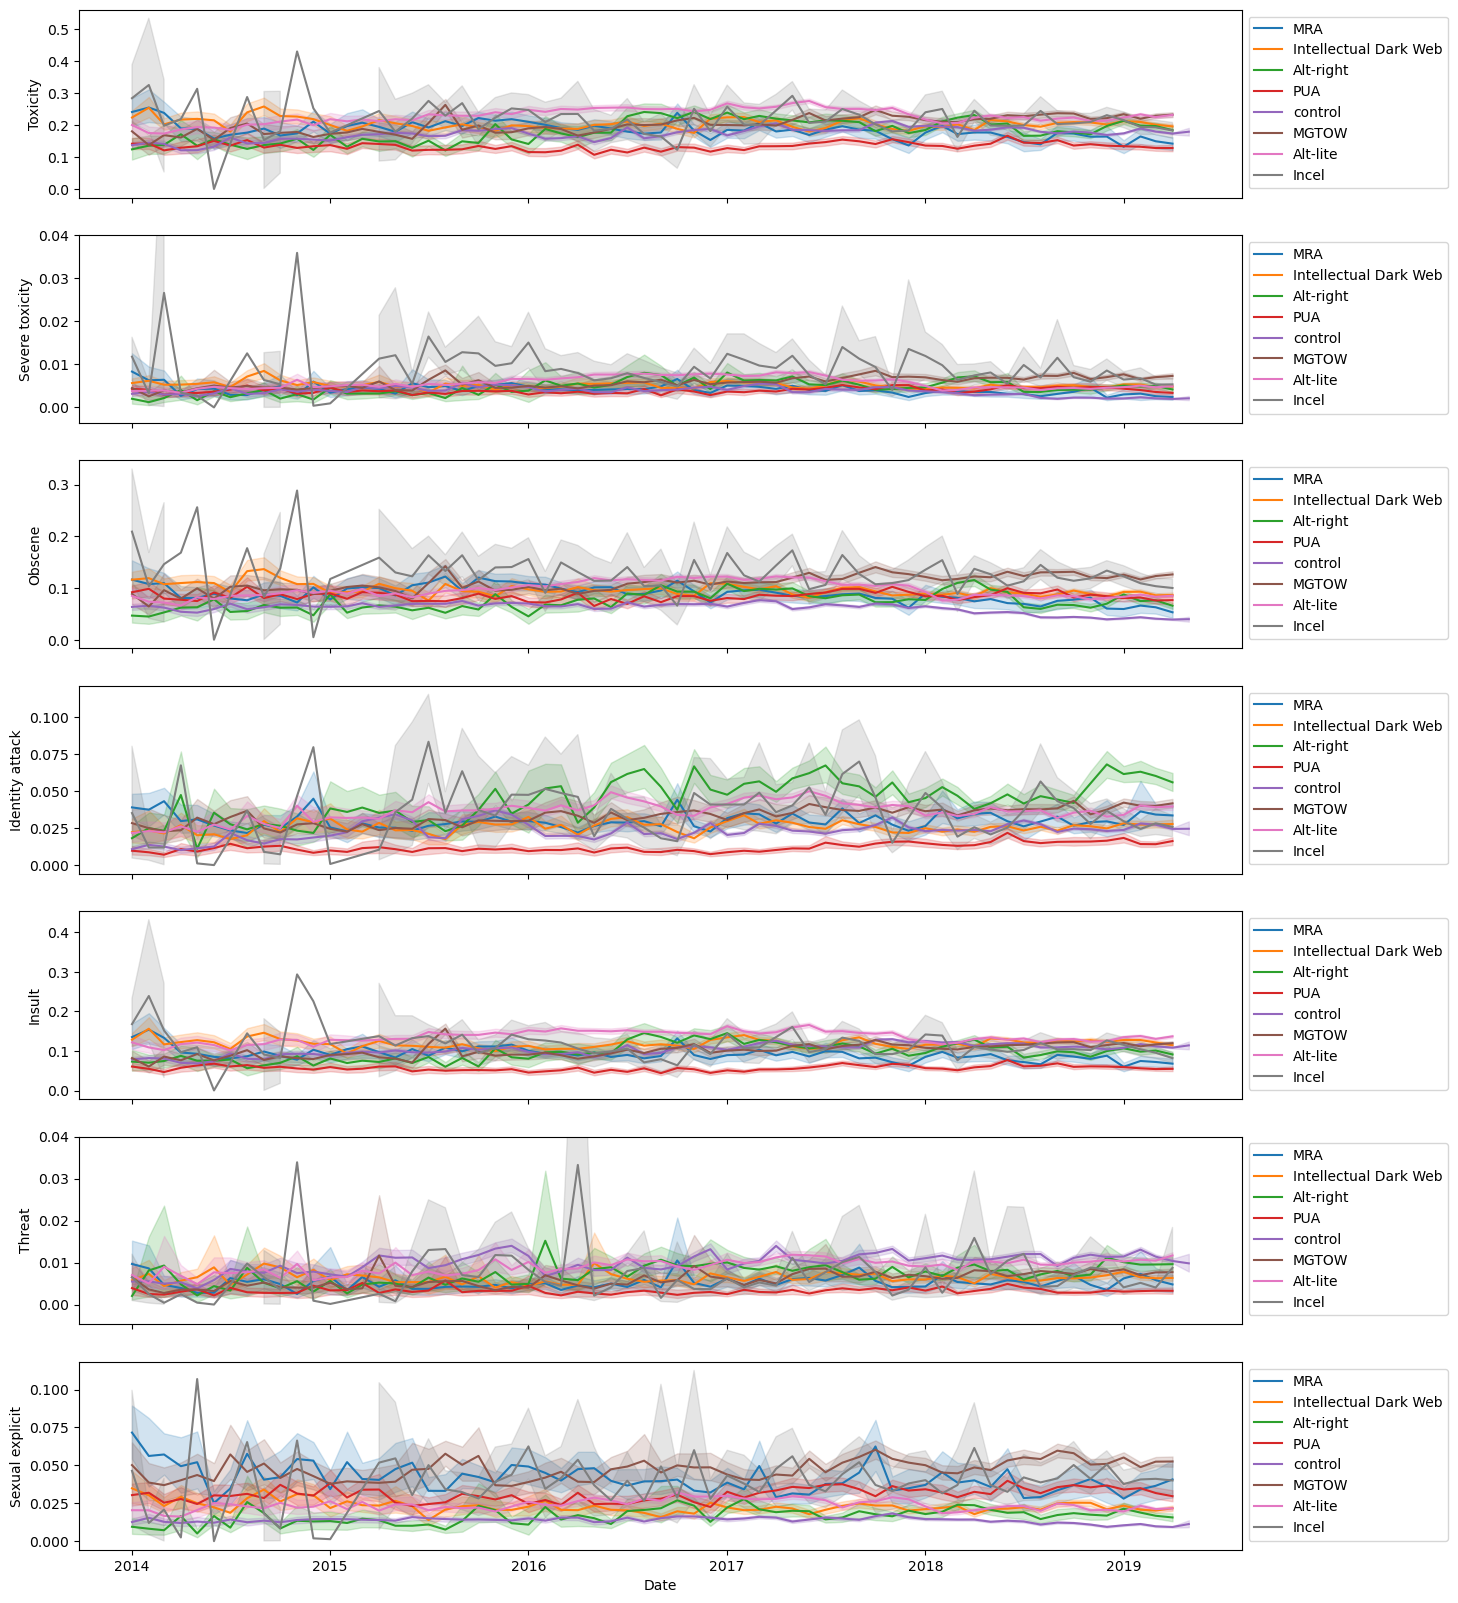

In [31]:
# takes about 1 min

fig, axs = plt.subplots(7,1, figsize=(15,20), sharex=True)

list_all_tox = ['toxicity'] + list_subcat_tox
list_all_tox_titles = ['Toxicity', 'Severe toxicity', 'Obscene', 'Identity attack', 'Insult', 'Threat', 'Sexual explicit']
small_scale = 0.04

for index, subcat_tox in enumerate(list_all_tox):
    for category in list_all_cat:
        sns.lineplot(x="month_created", y=subcat_tox, data=df_final_allcat[df_final_allcat['Category'] == category],
            label=category, ax = axs[index])
    axs[index].set_ylabel(list_all_tox_titles[index])
    axs[index].set_xlabel("Date")
    sns.move_legend(axs[index], "upper left", bbox_to_anchor=(1, 1))

axs[1].set_ylim(top = small_scale)
axs[5].set_ylim(top = small_scale)


For each category of toxicity, we observe different behaviours. 
* Toxicity: all right channel categories are above the control group. Alt-lite is at the top for the most time.
* Severe toxicity: (SMALL SCALE!) Incels are abnormally high. The other channels are comparable to the control group.
* Obscene: all right channel categories are above the control group. Incels and MGOTW are pretty high compare to the other ones.
* Identity attack: Alt-right is particularly high. Also PUA is lower than the control group.
* Insult: PUA lower than others. Alt-lite on top of the others.
* Threat: (SMALL SCALE!) Picks for incels. Control group seems higher than others. However small scale, so results overall are low, nothing significant.
* Sexual Explicit: MGTOW is higher. Control is low as expect. The other categories are higher.